# Simulation-Based Inference for decision-making models

This tutorial is based on the SBI tutorial [SBI for decision-making models](https://sbi.readthedocs.io/en/latest/tutorials/Example_01_DecisionMakingModel.html#inference-with-multiple-subjects-trials-and-conditions), an example how to use SBI with trial-based iid. data as they typically occur when modeling perceptual decision making experiments.
To show the power of the approach, we will assume mixed data types (continuous reaction times and categorical choices) and varying
experimental conditions (stimulus coherence). Here, we show how `sbi` can be used to perform inference in such models with the `MNLE` method.

For illustration we will fit a Drift-Diffusion Model where the drift scales with the coherence of the motion stimuli using the exact same data and model as in the previous [tutorial on fitting the DDM](https://github.com/bambschool/BAMB2025/blob/main/Day_6_DDM/bamb_tutorial5_ddm_solutions.ipynb) (section 3b). In this specific example we actually have access to the true likelihood (e.g. using PyDDM), but the same pipeline can be adapted for models that we can simulate but where we don't have access to the likelihood.

There are various methods for simulation-based inference (see for example [here](https://sbi-dev.github.io/sbi/latest/) for all methods covered by the SBI package). Here we will use **Mixed Neural Likelihood Estimation** (MNLE), which is particularly convenient for trial-based data with mixed output data types (e.g. continuous reaction times and categorical choices). The interested reader is referred to the original paper available [here](https://elifesciences.org/articles/77220) for details about how this actually works under the hood.

If you haven't installed `sbi` yet (or use Google Colab), run the cell below.
We also use the Bayesian Adaptive Direct Search (BADS) optimization algorithm [PyBADS](https://acerbilab.github.io/pybads/index.html) to find the maximum likelihood estimate.

In [1]:
!pip install sbi
!pip install pybads

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.1/383.1 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.5/906.5 MB 795.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 771.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.1 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as optimize

import torch
from pyro.distributions import InverseGamma
from torch import Tensor
from torch.distributions import Beta, Binomial, Categorical, Gamma, Uniform, Normal

from sbi.analysis import pairplot
from sbi.inference import MNLE, MCMCPosterior
from sbi.inference.potentials.base_potential import BasePotential
from sbi.inference.potentials.likelihood_based_potential import (
    MixedLikelihoodBasedPotential,
)
from sbi.utils import MultipleIndependent, mcmc_transform
from sbi.utils.conditional_density_utils import ConditionedPotential
from sbi.utils.metrics import c2st
from sbi.utils.torchutils import atleast_2d

# Load the data we wish to use
df_rt = pd.read_csv("https://raw.githubusercontent.com/mwshinn/PyDDM/master/doc/downloads/roitman_rts.csv")
df_rt = df_rt[df_rt["monkey"] == 1] # Only monkey 1

### 1. First create a function that simulates behavior, each trial with a different set of experimental conditions and model parameters.
Here we are simulating the standard DDM where drift is proportional to motion coherence $\nu= \text{driftscale} \cdot \text{coh}$. The model takes four parameters: the `drift_scale`, noise term `noise`, decision bound `bound` and non-decision time `ndt`. Because of the indeterminacy in the system there is one too many parameters and thus we will fix the boundary to 1 (another typical choice is to fix the noise to 1).
The difference from the function that we used in the DDM tutorial is that here the parameters are arrays, since their value can change on every trial.

In [3]:
# Run DDM, each trial with a different PARAMETER SET!
def run_ddm_varyingparameters(coh, drift_scale, noise, bound, ndt, dt=.01, T_dur=4):
    """
    Simulate single run of discrete DDM (stores trajectory of decision variable)

    [X, side, RT] = run_ddm_varyingparameters(coh, drift_scale, noise, bound, T_dur)

    Input:
        coh: coherence level
        drift_scale: scaling factor for drift rate
        noise: standard deviation of noise
        bound: the threshold (lower boundary corresponds to -a, upper boundary to a)
        ndt: non-decision time
        dt: time step for discretized version of dynamics
        T_dur: total runtime, in seconds

    Output:
        Choices: vector with choices, +1 if DV hits the upper boundary, -1 if DV hits the lower boundary)
        RT: reaction time

    """

    tmax = int(T_dur/dt);   # maximum number of time steps
    nTrial = len(drift_scale) # number of trials

    # compute drift_rate as coherence * drift_scale
    drift_rate = coh* drift_scale

    # Initialize decision variable x to 0
    x = np.zeros(nTrial)
    HitBoundary = np.zeros((nTrial), dtype=bool)
    Indices = np.arange(nTrial)
    nRemaining = nTrial
    Choices = np.zeros((nTrial))
    rt = np.zeros((nTrial))

    # Looping through time
    for t in range(tmax):
        x += drift_rate[~HitBoundary]*dt + np.sqrt(dt) * noise[~HitBoundary] * np.random.randn(nRemaining) # discrete DDM equation: update of decision variable

        # check which  trials where dv has just hit the boundaries
        JustHit = abs(x)>bound[~HitBoundary]

        if np.any(JustHit): # if any simulation has reached threshold
            i_just_hit = Indices[JustHit]
            HitBoundary[i_just_hit] = True #count them as 'boundary hit'
            nRemaining = nRemaining - len(i_just_hit) # update number of ongoing simulationsç

            new_decisions= np.sign(x[JustHit]) # which boundaries they've hit
            Choices[i_just_hit] = new_decisions # save corresponding decisions
            rt[i_just_hit] = t # and reaction time (in time steps)
            x = x[~JustHit] # keep simulating only trials where bound has not been reached
            Indices = Indices[~JustHit]

    # assign decisions for simulations that haven't reached boundary at the end
    new_decisions= np.sign(x)
    i_decisions = Indices
    Choices[i_decisions] = new_decisions
    rt[i_decisions] = tmax

    # convert time steps to actual time and add non-decision time
    rt = rt*dt + ndt
    return Choices, rt

### 2. Define prior distributions that will be used the define model parameters used to train the neural network.
Use a reasonable range of values where you want your network to approximate the likelihood well. The network will likely perform poorly outside the defined ranges.
For noise and non-decision time parameters, which are all positive by nature, we use gamma distributions with a concentration parameter that allows sampling a broad range while most of the density is concentrated around the most plausible values (shape parameter = 2).

In [4]:
# prior for drift scale (sensitivity): normal with 0-mean and std=5
DriftScalePrior = Normal(torch.tensor([0.0]), torch.tensor([5.0]))

# prior for drift scale (sensitivity): uniform between with -20 and 20
DriftScalePrior = Uniform(torch.tensor([-20.0]), torch.tensor([20.0]))

# Noise Prior: gamma distribution (shape=2, rate= 2 so that mean=shape/rate=1)
NoisePrior = Gamma(torch.tensor([2.0]), torch.tensor([2.0]))

# Non-decision time Prior: gamma distribution (shape=2, rate= 20/3 so that mean=shape/rate=0.3)
NDTPrior = Gamma(torch.tensor([2.0]), torch.tensor([20.0/3.0]))

# now compose the prior over ALL parameters as independent priors over each parameter
prior = MultipleIndependent([DriftScalePrior,NoisePrior,NDTPrior], validate_args=False)

### 3. Sample from this prior distribution to generate the experimental conditions and model parameters in the training dataset.
We need many trials to get a training set large enough to learn accurate approximations of the likelihood. But of course the computational cost of training the network (step 5) increases with sample size. We use 50.000 trials for acceptable enough approximations. We should use one order of magnitude larger (e.g. 500.000) for very accurate approximations but that would likely increase computation time to the order of several hours.  

In [5]:
#number of trials in the training set
N_simul = 50000

# generate values for experimental conditions (here just coherence values) for each trial, sampling from values in experimental data
coh_values= np.array((0., 0.032, 0.064,0.128, 0.256,0.512))
all_conditions = np.random.choice(coh_values,N_simul)

# generate values for model parameters, sampling from the priors we have just defined
param_values = prior.sample((N_simul,))

Let's plot the distributions over each parameter to make sure they match what we intended.

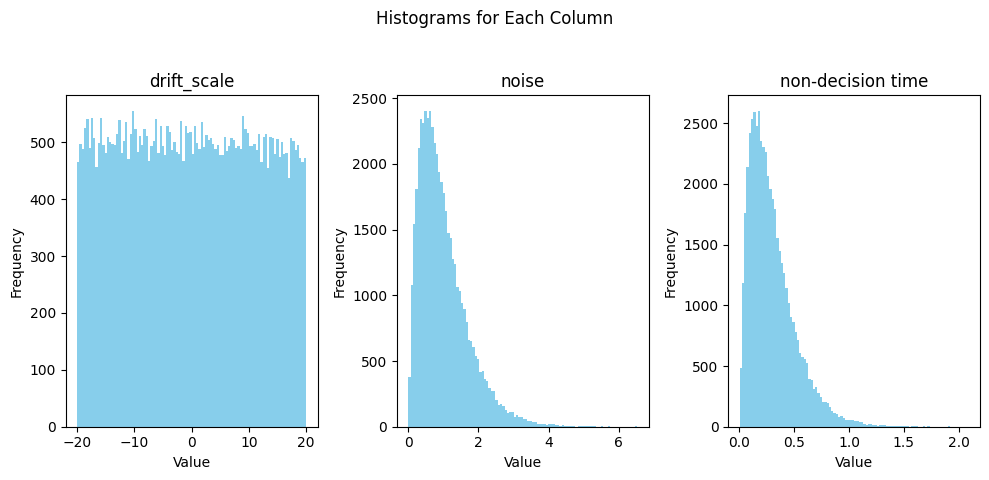

In [31]:
nParameter=3
ParamLabel = ("drift_scale","noise","non-decision time")

# Plot histograms for each column
fig, axes = plt.subplots(nrows=1, ncols=nParameter, figsize=(10, 5))
fig.suptitle('Histograms for Each Column')

for i, ax in enumerate(axes.flat):
    ax.hist(param_values[:, i].numpy(), bins=100, color='skyblue', edgecolor='none')
    ax.set_title(ParamLabel[i])
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### 4. Simulate our model, for the given number of trials and with the given experimental conditions and parameters varying on each trial.

In [7]:
# extract the columns from parameter array and convert to numpy
drift_scale = param_values[:,0].numpy()
noise = param_values[:,1].numpy()
ndt = param_values[:,2].numpy()
bound = np.ones(N_simul) # boundary is fixed at 1

# simulate all trials
choice, rt = run_ddm_varyingparameters(all_conditions, drift_scale, noise, bound, ndt, dt=.01, T_dur=4)

Let's just check the distribution of simulated reaction times to make sure they make sense.
Note that we get a secondary peak after 4 seconds because we imposed a response after 4 seconds of integration + non-decision time.

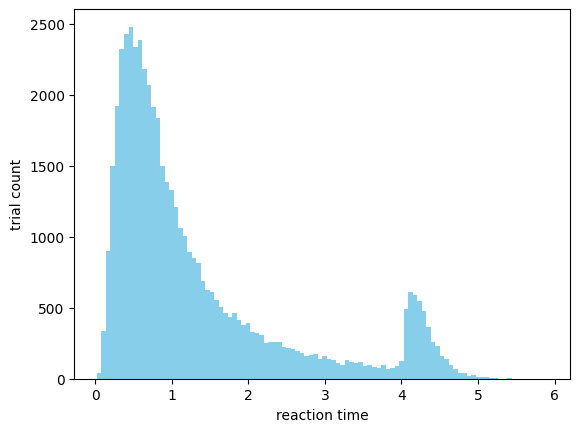

In [8]:
plt.figure;
plt.hist(rt, bins=100, color='skyblue', edgecolor='none');
plt.xlabel('reaction time');
plt.ylabel('trial count');

### 5. Now let's train the MNLE neural network to learn the density of behavioral data (choices and reaction times) for given parameters and experimental conditions.
We use the training data to train an neural network to approximate the conditional likelihood of data $x$ given parameters $\theta$, i.e. $p(x|\theta,s)$ - in our case, data = (choices, RT), parameters = (drift_scale, noise, non-decision time), conditions = (coh).

Note that this will take a few minutes (or hours if you use more training data).

In [9]:
# concatenate parameters and experimental conditions into single torch array
all_cond = torch.tensor(all_conditions,dtype=torch.float32)
input = torch.cat((param_values,all_cond.reshape((N_simul,1))),dim=1) # input to neural net = parameters + conditions

# concatenate behavioral data (choice+RT) into torch array (the continuous variable - RT - must come before the categorical one - choice !)
rt_torch = torch.tensor(rt,dtype=torch.float32)
choice_torch = torch.tensor(choice,dtype=torch.float32)
choice_torch[choice_torch == -1] = 0 # !!! MNLE doesn't want negative values for choice so we're recoding to 0 for lower bound choices
output = torch.cat((rt_torch.reshape((N_simul,1)), choice_torch.reshape((N_simul,1))),dim=1)

# create MNLE object
trainer = MNLE()

# add simulations (input = parameters, output = behavior)
trainer = trainer.append_simulations(input, output)

# train the neural network: the estimator object now approximates the likelihood (conditioned on parameters)
#estimator = trainer.train(training_batch_size=1000)
estimator = trainer.train()

/usr/local/lib/python3.11/dist-packages/sbi/neural_nets/factory.py:207: UserWarning: The mixed neural likelihood estimator assumes that x contains continuous data in the first n-k columns (e.g., reaction times) and categorical data in the last k columns (e.g., corresponding choices). If this is not the case for the passed `x` do not use this function.
  return model_builders[model](batch_x=batch_x, batch_y=batch_theta, **kwargs)
/usr/local/lib/python3.11/dist-packages/sbi/neural_nets/net_builders/mnle.py:156: UserWarning: Inferring num_categories from batch_x. Ensure all categories are present.
  discrete_net = build_categoricalmassestimator(


 Neural network successfully converged after 71 epochs.

### 6. Testing MNLE

We compare the likelihood provided by MNLE for a given set of parameters to the distributions obtained by simulating repeatedly the model for these same set of parameters and experimental conditions. We access the likelihoods of the reaction time and choices, given the underlying parameter, by calling `.log_prob()`.

You can try parameters outside of the training range to see how the approximation breaks downs (expectedly).

In [10]:
import ipywidgets as widgets       # interactive display

@widgets.interact(
    drift_scale=widgets.FloatSlider(5.0, min=-20.0, max=20.0), # defaul, min and max values for drift scale parameter
    noise=widgets.FloatSlider(1.0, min=0.0, max=2.0), # default, min and max values for noise param
    ndt=widgets.FloatSlider(0.2, min=0.0, max=2.0), # default, min and max values for non-decision time param
    coh=widgets.FloatSlider(0.5, min=0.0, max=1.0)) # default, min and max values for coherence (experimental condition)

def plot_mnle_vs_data(drift_scale, noise,ndt,coh):

    # fixed parameter
    bound = 1 # fixed to 1

   # maxRT: range of reaction time to be plotted
    maxRT=3

    nSimul=10000 # number of simulated trials

    # 1. simulate more trials from the model, now using a fixed set of parameters and conditions

    # simulate data
    ones = np.ones(nSimul)
    choice_chk, rt_chk = run_ddm_varyingparameters(coh*ones, drift_scale*ones, noise*ones, bound*ones, ndt*ones)

    # To be able to plot the data in 1D we sign rt by choice.
    rt_choice = choice_chk * rt_chk

    # 2. Now compute the likelihoods of reaction times and choices according to the trained network.

    # Construct test reaction times.
    test_data = torch.linspace(-maxRT, maxRT, 1000)

    # Separate rts and choices.
    test_rts = abs(test_data)
    test_cs = torch.ones_like(test_data) # choice 1 for "positive RTs"
    test_cs[test_data < 0] = 0 # choice 0 for "negative RTs"
    test_x = torch.stack((test_rts, test_cs), dim=1)

    # concatenate parameters and experimental conditions into pytorch vector
    theta_o = torch.tensor((drift_scale,noise,ndt,coh))

    # Get the log likelihood of the entire range of reaction times and choices.
    mnle_loglikelihoods = estimator.log_prob(test_x.unsqueeze(1).detach(), theta_o.unsqueeze(0).detach())
    mnle_loglikelihoods=mnle_loglikelihoods.detach()

    # 3. And compare the simulations and the likelihood as given by MNLE.

    # Plot the real simulated data,  and the learned synthetic likelihoods.
    plt.figure(figsize=(12, 6))
    density = True

    # Plot real data on top,
    plt.hist(
        rt_choice,
        bins=np.linspace(-maxRT, maxRT, 101),
        alpha=0.5,
        color="C1",
        label="real data from the model",
        density=density,
    )
    # and the MNLE likelihoods (we exponentiate the log-likelihoods to retrieve likelihoods)
    plt.plot(
        test_data, mnle_loglikelihoods.exp(), label="MNLE likelihood", ls="-", c="green"
    )
    plt.legend();
    plt.show(); # needed for Colab

interactive(children=(FloatSlider(value=5.0, description='drift_scale', max=20.0, min=-20.0), FloatSlider(valu…

If the widget does not work simply use it like this:

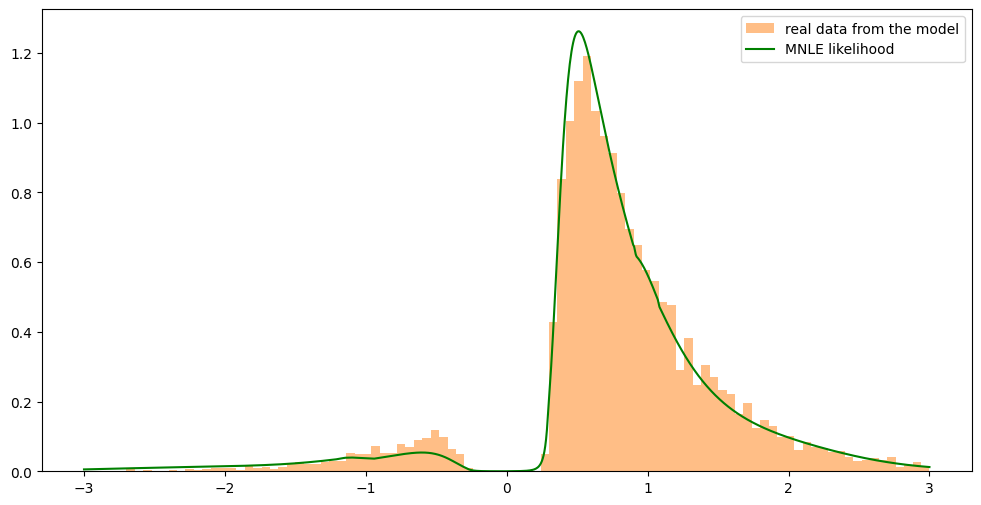

In [11]:
#plot_mnle_vs_data(drift_scale, noise,ndt,coh)
plot_mnle_vs_data(3, 1,.2,.4)

It's usually a good idea at this point to **save the trained network** in the pickle file, so you don't have to redo everything again in case your session crashes.

In [28]:
import pickle

with open("mnle_trained_network.pkl", "wb") as handle:
    pickle.dump((estimator,trainer), handle)

/tmp/ipython-input-28-2707405233.py:4: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  pickle.dump((estimator,trainer), handle)


If you want to take it from here without retraining your network, uncomment the code below to load the pickle file where the trained network has been stored.

In [29]:
## Load objects from a pickle file
#with open('mnle_trained_network.pkl', 'rb') as file:
#    estimator, trainer = pickle.load(file)

### 7. Find maximum-likelihood estimates
Here we will not use a Bayesian approach with MCMC but simply find the maximum likelihood estimates for our experimental dataset, using the approximate likelihood function provided by MNLE (instead of the true likelihood which we do not have access to).

In [12]:
from pybads import BADS
from sbi.inference.potentials.likelihood_based_potential import LikelihoodBasedPotential

# THIS PART YOU SHOULD ADAPT TO YOUR OWN MODEL AND DATA

#select relevant variables from your dataframe
# IMPORTANT: place experimental conditions first, behavioral measures last
df_sub = df_rt[['coh','rt','correct']]
nConditions = 1 # here only one experimental condition: stimulus
nParameter = 3
display="iter" #display option for BADS

# convert to pytorch tensor
# (we already had it but this is just to show how this would work with a real example)
data_torch = torch.tensor(df_sub.to_numpy()).to(torch.float32)

output_data = data_torch[:,nConditions:] # output data: selecting rts and choices from experimental dataset
conditions=data_torch[:,:nConditions] # experimental conditions (coherence=1st column)

# First, we define the potential function for the complete, unconditional MNLE-likelihood
# The unconditioned potential function expects input in the format [parameters, conditions]
# The output is the likelihood of the behavioral data.
# So the proposal here should match the combined parameter and condition space used for training.
# However, for LikelihoodBasedPotential, the proposal is mainly used for MCMC initialization
# and doesn't need to match the exact training proposal structure.
# Let's keep it as the parameter prior for now, as that's what we are sampling over with BADS.
proposal=prior

potential_fn = LikelihoodBasedPotential(estimator, proposal)

# Then, we condition on the experimental conditions from the observed data.
# The conditioned potential function will now expect only the parameters (theta)
# and the observed data (x_o), which should include both conditions and behavioral data.
conditioned_potential_fn = potential_fn.condition_on_theta(
    conditions,  # pass the observed conditions
    dims_global_theta=range(nParameter)  # indices of parameters in the original input to the unconditioned potential
)

# define function to be minimized by BADS (negative log-likelihood)
# The conditioned_potential_fn expects theta and x_o (full observed data).
# We need to ensure x_o has the correct shape for the estimator's log_prob: (sample_dim, batch_dim, *event_shape)
# sample_dim = 1, batch_dim = num_trials, event_shape = 2 (RT, choice)
# data_torch[:, nConditions:] gives us the behavioral data with shape (num_trials, 2)
# We need to reshape it to (1, num_trials, 2)
def ModelNegLogLikelihood(theta,conditioned_potential_fn=conditioned_potential_fn):
  theta_t = torch.tensor(theta).float().unsqueeze(0)
  LLH=conditioned_potential_fn(theta_t,output_data.unsqueeze(1))
  return -LLH.detach().numpy()

# Define the bounds for each parameter
drift_scale_bounds = (-20, 20)
noise_bounds = (0.01, 10)
ndt_bounds = (0.01, 10)
bounds = [drift_scale_bounds, noise_bounds,ndt_bounds]
lb = [bounds[ii][0] for ii in range(nParameter)] #plausible lower bound
ub = [bounds[ii][1] for ii in range(nParameter)] #plausible upper bound

# Define plausible bounds for each parameter (for BADS)
drift_scale_pbounds = (-1, 10)
noise_pbounds = (0.1, 3)
ndt_pbounds = (0.05, 1)
pbounds = [drift_scale_pbounds, noise_pbounds,ndt_pbounds]
plb = [pbounds[ii][0] for ii in range(nParameter)] #plausible lower bound
pub = [pbounds[ii][1] for ii in range(nParameter)] #plausible upper bound

# Initial guess for parameter set
x0 = [1, 1,1]

# define optimizer (BADS)
bads = BADS(ModelNegLogLikelihood, x0, lb, ub, plb, pub, options = {"display" : display})

# optimization
result = bads.optimize()
print("took ",result.total_time, " seconds")

# Retrieve the optimized parameters
(drift_scale_hat, noise_hat,ndt_hat) = result.x

# print
print("drift_scale_hat =",drift_scale_hat)
print("noise_hat =",noise_hat)
print("ndt_hat =",ndt_hat)

INFO:BADS:Variables (index) internally transformed to log coordinates: [[0 1]
 [0 2]]
INFO:BADS:Beginning optimization of a DETERMINISTIC objective function

INFO:BADS: Iteration    f-count         f(x)           MeshScale          Method             Actions
INFO:BADS:     0           2         28066.5               1                                 Uncertainty test
INFO:BADS:     0           6         1086.34               1         Initial mesh            Initial points
INFO:BADS:     0           7         523.918               1       Successful poll           Train
INFO:BADS:     1          17         523.856             0.5         Refine grid             Train
INFO:BADS:     2          19         278.921             0.5     Successful search (ES-ell)        
INFO:BADS:     2          22         253.194             0.5     Successful search (ES-ell)        
INFO:BADS:     2          24         217.496             0.5     Successful search (ES-ell)        
INFO:BADS:     2         

took  22.773695946739746  seconds
drift_scale_hat = 14.921904645860195
noise_hat = 1.4526746578954004
ndt_hat = 0.32770351046637597


### 8. Bayesian fitting with MCMC

Finally, we use a sampling-based method to estimate the full posterior distribution of the model parameters. For computational reason we will use only 50 trials from the experimental dataset (some tweaking of the parameters of the sampling method should be done to allow estimating the posterior from the full dataset).

In [22]:
from sbi.inference.potentials.likelihood_based_potential import LikelihoodBasedPotential
num_samples = 1000 # number of samples from posterior over parameters
nTrialSubset = 50 # how many trials we use for fitting

# Here we use the exact same prior over parameters that was used to generate parameter values in the training dataset,
#but the prior could be adjusted to our dataset
prior_transform = mcmc_transform(prior)

output_data = data_torch[:nTrialSubset,1:] # output data: selecting rts and choices from experimental dataset
conditions=data_torch[:nTrialSubset,:1] # experimental conditions (coherence=1st column)

# First, we define the potential function for the complete, unconditional MNLE-likelihood
proposal=prior #!! probably will need to add fake prior for conditions
potential_fn = LikelihoodBasedPotential(estimator, proposal)
# Then, we condition on the experimental conditions.
conditioned_potential_fn = potential_fn.condition_on_theta(
    conditions,  # pass only the conditions
    dims_global_theta=range(nParameter)  # pass the identities of columns that correspond to model parameters (and not experimental conditions), here the first 3
)

mcmc_kwargs = dict(
    num_chains=3, # Reduced number of chains
    warmup_steps=100,
    init_strategy="resample",
    thin=1,
    num_workers=4
)

# Using this potential function, we can now obtain conditional samples.
mnle_posterior = MCMCPosterior(
    potential_fn=conditioned_potential_fn,  # pass the conditioned potential function
    theta_transform=prior_transform,
    proposal=prior
)

conditional_samples = mnle_posterior.sample((num_samples,), x=output_data,mcmc_parameters={'sample_with':'slice_np'})

/usr/local/lib/python3.11/dist-packages/sbi/inference/posteriors/mcmc_posterior.py:115: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)
/tmp/ipython-input-22-3170084181.py:41: UserWarning: You passed `mcmc_parameters` to `.sample()`. As of sbi v0.18.0, this is deprecated and will be removed in a future release. Instead, pass the variable to `.sample()` directly, e.g. `posterior.sample((1,), num_chains=5)`.
  conditional_samples = mnle_posterior.sample((num_samples,), x=output_data,mcmc_parameters={'sample_with':'slice_np'})


Generating 20 MCMC inits via resample strategy:   0%|          | 0/20 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/6000 [00:00<?, ?it/s]

Finally we represent the posterior distribution over each parameter in the following plot, which quantifies the degree of uncertainty about those values (using a larger dataset would allow to get narrower distributions)

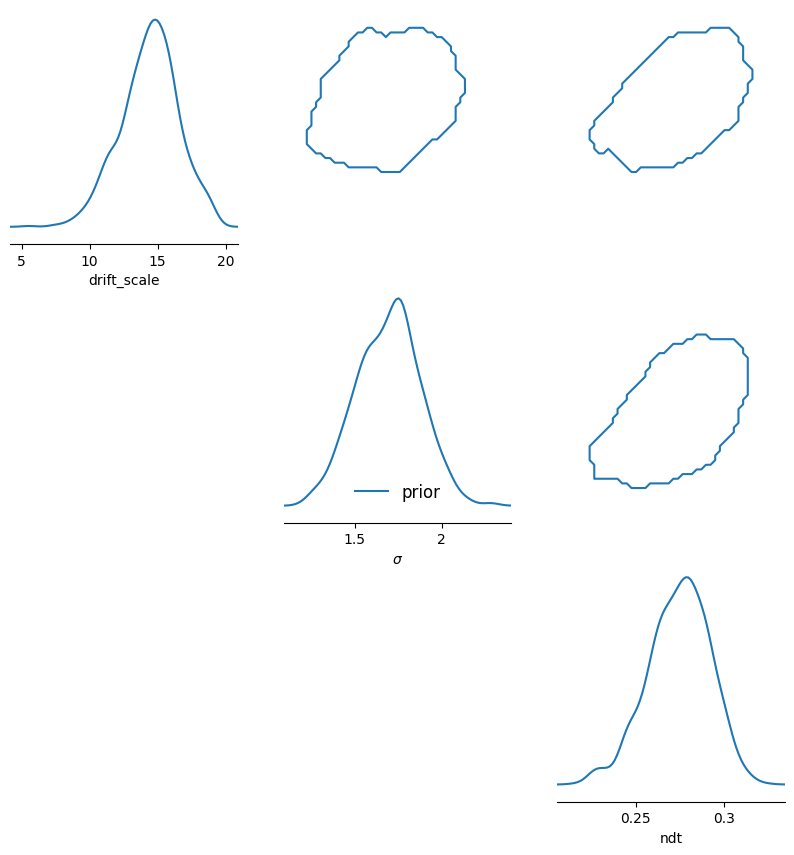

In [23]:
# Plotting all three posteriors in one pairplot.

fig, ax = pairplot(
    conditional_samples,
    diag="kde",
    upper="contour",
    diag_kwargs=dict(bins=100),
    upper_kwargs=dict(levels=[0.95]),
    fig_kwargs=dict(
        points_offdiag=dict(marker="*", markersize=10),
        points_colors=["k"],

    ),
    labels=[r"drift_scale", r"$\sigma$",r"ndt"],
    figsize=(10, 10),
)

plt.sca(ax[1, 1])
plt.legend(
    ["prior"] + [f"Subject {idx+1}" for idx in range(3)],
    frameon=False,
    fontsize=12,
);